# Grassmann Manifold

Author: Ketson R. M. dos Santos,  
Date: March 24, 2020   

This example shows how to use the UQpy Grassmann class to
* compute the Karcher mean;
* map the points on the Grassmann manifold on the tangent space and vice versa;
* interpolate a sample in the tangent space.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the Grassmann class from UQpy implemented in the DimensionReduction module.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from DimensionReduction import Grassmann
from Utilities import svd

Generate the initial samples located at the vertices of a triangle. The coordinates of each vertix are stored in `nodes` and `point` contain the point to be interpolated on the tangent space.

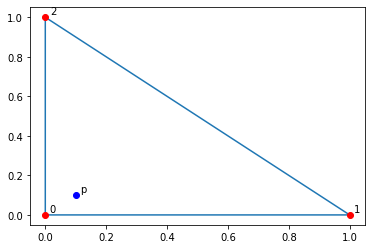

In [2]:
nodes = np.array([[0, 0], [1, 0], [0, 1]]) # node_0, node_1, node_2.
point = np.array([0.1, 0.1]) # Point to interpolate.

plot_ = nodes[0:]
Xplot = plot_.T[0].tolist()
Xplot.append(plot_[0][0])
Yplot = plot_.T[1].tolist()
Yplot.append(plot_[0][1])
plt.plot(Xplot,Yplot)
plt.plot(nodes[0][0],nodes[0][1],'ro')
plt.plot(nodes[1][0],nodes[1][1],'ro')
plt.plot(nodes[2][0],nodes[2][1],'ro')
plt.plot(point[0],point[1],'bo')

dt = 0.015
plt.text(nodes[0][0]+dt,nodes[0][1]+dt,'0')
plt.text(nodes[1][0]+dt,nodes[1][1]+dt,'1')
plt.text(nodes[2][0]+dt,nodes[2][1]+dt,'2')
plt.text(point[0]+dt,point[1]+dt,'p')
plt.show()
plt.close()


Generate three random matrices with reduced rank corresponding to the different samples. The samples are stored in `Solutions`.

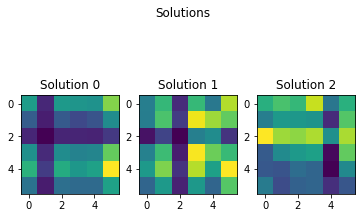

In [3]:
D1 = 6 
r0 = 2  # rank sample 0
r1 = 3  # rank sample 1
r2 = 4  # rank sample 2

np.random.seed(1111) # For reproducibility.
# Solutions: original space.
Sol0 = np.dot(np.random.rand(D1, r0),np.random.rand(r0, D1))
Sol1 = np.dot(np.random.rand(D1, r1),np.random.rand(r1, D1))
Sol2 = np.dot(np.random.rand(D1, r2),np.random.rand(r2, D1))

# Creating a list of solutions.
Solutions = [Sol0, Sol1, Sol2]

# Plot the solutions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Solutions')
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
plt.show()

Instatiate the UQpy class Grassmann considering the `"grassmann_distance"` as the a definition of distance on the manifold. Further, the method `project_points` is employed to project the solution on the Grassmann manifold where the left and right -singular vectors and the singular values are computed. Moreover, also the rank of each solution as the maximum rank among all the solutions are provided.

In [4]:
# Project each point onto the Grassmann manifold and estimate the ranks.
Gr = Grassmann(distance_object="grassmann_distance", interp_object="linear_interp",kernel_object="projection_kernel", karcher_object="gradient_descent")

psi, sigma, phi, max_rank, rank = Gr.project_points(Solutions)
phi = np.array([phi[0].T, phi[1].T, phi[2].T]) # Taking the transpose.

Compute the Karcher mean for $\Psi$ and $\Phi$, the left and right -singular eigenvectors, respectively, of singular value decomposition of each solution.

In [5]:
karcher_mean_Psi = Gr.karcher_mean(psi, acc=True, tol=1e-3, maxiter=1000)
karcher_mean_Phi = Gr.karcher_mean(phi, acc=True, tol=1e-3, maxiter=1000)

Rearrange the singular values $\Sigma$ of each solution as a diagonal matrix.

In [6]:
print(sigma)

sigma_m = []
for i in range(len(sigma)):
    sigma_m.append(np.diag(sigma[i]))

[array([3.15151543e+00, 1.01592369e-01, 2.69674168e-16, 7.74655398e-17]), array([4.45175241e+00, 5.69544093e-01, 1.19793937e-01, 1.69307663e-16]), array([6.32474411, 0.73398804, 0.3728332 , 0.15442486])]


Select the Karcher mean as a reference point for $\Psi$ and $\Phi$ and map those points on the manifold to the tangent space generated at the reference point.

In [7]:
ref_psi = karcher_mean_Psi
ref_phi = karcher_mean_Phi

gammaPsi = Gr.log_mapping(psi, ref=ref_psi, rank_ref=max_rank)
gammaPhi = Gr.log_mapping(phi, ref=ref_phi, rank_ref=max_rank)

Perform the standard linear interpolation of `point` on the tangent space for $\Psi$, $\Phi$, and $\Sigma$. The interpolated points are given by $\tilde{\Psi}$, $\tilde{\Phi}$, and $\tilde{\Sigma}$. Thus, the interpolated solution is given by $\tilde{\mathrm{X}}=\tilde{\Psi}\tilde{\Phi}\tilde{\Sigma}$.

In [8]:
interpPsi = Gr.interpolate_sample(gammaPsi, coordinates=nodes, point=point)
interpPhi = Gr.interpolate_sample(gammaPhi, coordinates=nodes, point=point)
interpS = Gr.interpolate_sample(sigma_m, coordinates=nodes, point=point)

PsiTilde = Gr.exp_mapping(interpPsi, ref=ref_psi,rank_ref=max_rank)
PhiTilde = Gr.exp_mapping(interpPhi, ref=ref_phi,rank_ref=max_rank)

print(np.shape(PsiTilde))
PsiTilde = np.array(PsiTilde[0])
PhiTilde = np.array(PhiTilde[0])
SolTilde = np.dot(np.dot(PsiTilde, interpS),PhiTilde.T)

(1, 6, 4)


Print the interpolated solution and compare to the given solutions associated to the different vertices of the triangle.

[[0.65058578 0.15997151 0.63279076 0.61285645 0.60173658 0.94037845]
 [0.36356653 0.12756156 0.34794897 0.28160916 0.32153957 0.57679911]
 [0.15529489 0.03544985 0.15145383 0.15065183 0.14469022 0.2207925 ]
 [0.59300055 0.16563232 0.57383432 0.52699713 0.54082604 0.88377849]
 [0.74489157 0.23393673 0.71696915 0.62070422 0.6693657  1.14492744]
 [0.45643461 0.12005378 0.44278736 0.41748883 0.41914465 0.67025722]]
 
[[0.60966666 0.83740533 0.31712613 0.84306651 0.58301809 1.04881107]
 [0.60785235 0.88596601 0.36718095 1.13323508 1.01713178 0.92996841]
 [0.2464859  0.39818036 0.20049917 0.61497793 0.66483533 0.34348345]
 [0.62238022 0.85848369 0.2767713  1.15025462 0.94342018 0.84554589]
 [0.71519376 0.97392451 0.34238686 1.05344459 0.7450903  1.15847017]
 [0.51218462 0.71530438 0.29063148 0.70981172 0.51250408 0.90768646]]
 
[[1.19651614 1.32294781 1.25181197 1.62903871 0.83929742 1.20041643]
 [0.89296687 1.0550084  1.04233584 1.02247984 0.43543934 1.35114872]
 [1.75345633 1.53238807 1.49

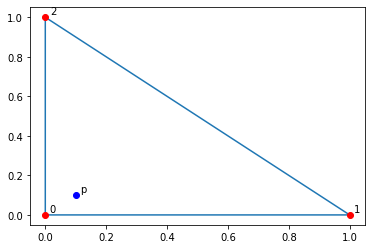

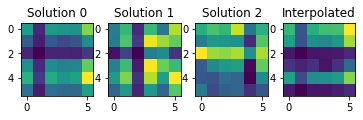

In [9]:
print(Sol0)
print(" ")
print(Sol1)
print(" ")
print(Sol2)
print("-------------------------")
print(SolTilde)

plot_ = nodes[0:]
Xplot = plot_.T[0].tolist()
Xplot.append(plot_[0][0])
Yplot = plot_.T[1].tolist()
Yplot.append(plot_[0][1])
plt.plot(Xplot,Yplot)
plt.plot(nodes[0][0],nodes[0][1],'ro')
plt.plot(nodes[1][0],nodes[1][1],'ro')
plt.plot(nodes[2][0],nodes[2][1],'ro')
plt.plot(point[0],point[1],'bo')

dt = 0.015
plt.text(nodes[0][0]+dt,nodes[0][1]+dt,'0')
plt.text(nodes[1][0]+dt,nodes[1][1]+dt,'1')
plt.text(nodes[2][0]+dt,nodes[2][1]+dt,'2')
plt.text(point[0]+dt,point[1]+dt,'p')
plt.show()
plt.close()


# Plot the solutions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
ax4.title.set_text('Interpolated')
ax4.imshow(SolTilde)
plt.show()